## Traffic Sign Detection Using neural network and image preprocessing

### Importing the libraries

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

### Parameters

In [4]:
path = "myData" # folder with all the class folders
labelFile = 'labels.csv' # file with all names of classes
batch_size_val=50  # how many to process together
steps_per_epoch_val=2000
epochs_val=20
imageDimesions = (32,32,3)
testRatio = 0.2    # if 1000 images split will 200 for testing
validationRatio = 0.2 # if 1000 images 20% of remaining 800 will be 160 for validation


### Importing Images

In [5]:

count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses=len(myList)
print("Importing Classes.....")
for x in range (0,len(myList)):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(count)+"/"+y)
        images.append(curImg)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


### Spliting of data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)
 
# X_train = ARRAY OF IMAGES TO TRAIN
# y_train = CORRESPONDING CLASS 

### Checking the No. Of Images Matches to No. of labels for each set 

In [7]:
print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)
assert(X_train.shape[0]==y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert(X_validation.shape[0]==y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert(X_test.shape[0]==y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert(X_train.shape[1:]==(imageDimesions))," The dimesions of the Training images are wrong "
assert(X_validation.shape[1:]==(imageDimesions))," The dimesionas of the Validation images are wrong "
assert(X_test.shape[1:]==(imageDimesions))," The dimesionas of the Test images are wrong"

Data Shapes
Train(22271, 32, 32, 3) (22271,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)


### Read the CSV

In [8]:
data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


### Display some samples Images of all the classes

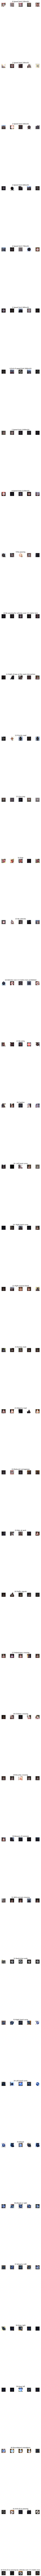

In [9]:
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)- 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-"+row["Name"])
            num_of_samples.append(len(x_selected))

### Display a Bar Chart,showing no of samples for each class

[112, 1242, 1299, 806, 1127, 1059, 229, 809, 773, 809, 1176, 753, 1244, 1208, 447, 343, 233, 636, 681, 124, 206, 186, 206, 272, 151, 882, 327, 141, 324, 156, 260, 444, 125, 401, 233, 700, 214, 117, 1185, 167, 191, 138, 135]


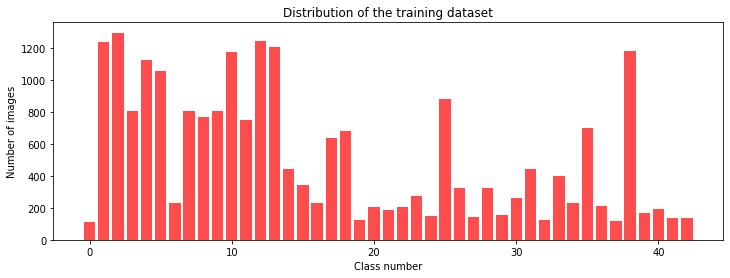

In [10]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples,color='red',alpha=0.7)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

### Image Preprocessing 

In [11]:

 
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)     # CONVERT TO GRAYSCALE
    img = equalize(img)      # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img/255            # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img
 
X_train=np.array(list(map(preprocessing,X_train)))  # TO IRETATE AND PREPROCESS ALL IMAGES
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test)))
cv2.imshow("GrayScale Images",X_train[random.randint(0,len(X_train)-1)]) # TO CHECK IF THE TRAINING IS DONE PROPERLY

In [12]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

### Images Augmentation

In [13]:
dataGen= ImageDataGenerator(width_shift_range=0.1,   # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                            height_shift_range=0.1,
                            zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                            shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                            rotation_range=10)  # DEGREES
dataGen.fit(X_train)
batches= dataGen.flow(X_train,y_train,batch_size=20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREATED EACH TIME ITS CALLED
X_batch,y_batch = next(batches)

### Image Samples

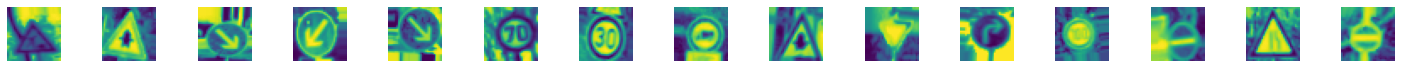

In [14]:
fig,axs=plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimesions[0],imageDimesions[1]))
    axs[i].axis('off')
plt.show()
 
 
y_train = to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)

### Convolutional Neural Network Model 

In [15]:

def myModel():
    no_Of_Filters=60
    size_of_Filter=(5,5) # THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
                         # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 32 32 IMAGE
    size_of_Filter2=(3,3)
    size_of_pool=(2,2)  # SCALE DOWN ALL FEATURE MAP TO GERNALIZE MORE, TO REDUCE OVERFITTING
    no_Of_Nodes = 500   # NO. OF NODES IN HIDDEN LAYERS
    model= Sequential()
    model.add((Conv2D(no_Of_Filters,size_of_Filter,input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool)) # DOES NOT EFFECT THE DEPTH/NO OF FILTERS
 
    model.add((Conv2D(no_Of_Filters//2, size_of_Filter2,activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))
 
    model.add(Flatten())
    model.add(Dense(no_Of_Nodes,activation='relu'))
    model.add(Dropout(0.5)) # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
    model.add(Dense(noOfClasses,activation='softmax')) # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

### Model Training

In [16]:

model = myModel()
print(model.summary())
history=model.fit_generator(dataGen.flow(X_train,y_train,batch_size=batch_size_val),#steps_per_epoch=steps_per_epoch_val,
                            epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 30)          0

c:\users\akshay\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


446/446 [==============================] - 153s 298ms/step - loss: 3.2407 - accuracy: 0.1331 - val_loss: 0.9368 - val_accuracy: 0.7475
Epoch 2/20
446/446 [==============================] - 133s 297ms/step - loss: 1.5109 - accuracy: 0.5414 - val_loss: 0.3832 - val_accuracy: 0.9159
Epoch 3/20
446/446 [==============================] - 131s 295ms/step - loss: 1.0019 - accuracy: 0.6883 - val_loss: 0.2113 - val_accuracy: 0.9479
Epoch 4/20
446/446 [==============================] - 145s 326ms/step - loss: 0.7621 - accuracy: 0.7628 - val_loss: 0.1432 - val_accuracy: 0.9580
Epoch 5/20
446/446 [==============================] - 134s 299ms/step - loss: 0.6296 - accuracy: 0.8000 - val_loss: 0.1140 - val_accuracy: 0.9734
Epoch 6/20
446/446 [==============================] - 134s 300ms/step - loss: 0.5294 - accuracy: 0.8330 - val_loss: 0.1681 - val_accuracy: 0.9450
Epoch 7/20
446/446 [==============================] - 133s 299ms/step - loss: 0.4644 - accuracy: 0.8519 - val_loss: 0.0827 - val_accura

### Plots for Accuracy & loss

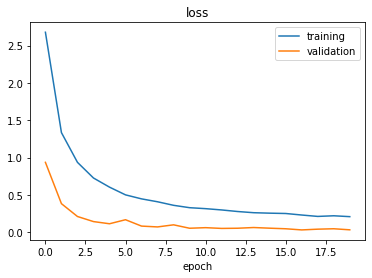

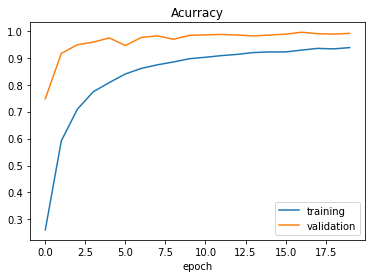

Test Score: 0.03183166682720184
Test Accuracy: 0.9903735518455505


In [17]:

plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

### Saving the Model

In [18]:
model.save('model_trained.h5')

### Webcam Parameters

In [10]:

 
frameWidth= 640         # CAMERA RESOLUTION
frameHeight = 480
brightness = 180
threshold = 0.75         # PROBABLITY THRESHOLD
font = cv2.FONT_HERSHEY_SIMPLEX

### Setting up the Video Camera

In [11]:

cap = cv2.VideoCapture(0)
cap.set(3, frameWidth)
cap.set(4, frameHeight)
cap.set(10, brightness)

True

### Loading the Trained Model

In [12]:
model=load_model('model_trained.h5')

In [13]:
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img =cv2.equalizeHist(img)
    return img

def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

def getCalssName(classNo):
    if   classNo == 0: return 'Speed Limit 20 km/h'
    elif classNo == 1: return 'Speed Limit 30 km/h'
    elif classNo == 2: return 'Speed Limit 50 km/h'
    elif classNo == 3: return 'Speed Limit 60 km/h'
    elif classNo == 4: return 'Speed Limit 70 km/h'
    elif classNo == 5: return 'Speed Limit 80 km/h'
    elif classNo == 6: return 'End of Speed Limit 80 km/h'
    elif classNo == 7: return 'Speed Limit 100 km/h'
    elif classNo == 8: return 'Speed Limit 120 km/h'
    elif classNo == 9: return 'No passing'
    elif classNo == 10: return 'No passing for vehicles over 3.5 metric tons'
    elif classNo == 11: return 'Right-of-way at the next intersection'
    elif classNo == 12: return 'Priority road'
    elif classNo == 13: return 'Give Way'
    elif classNo == 14: return 'Stop'
    elif classNo == 15: return 'No vehicles'
    elif classNo == 16: return 'Vehicles over 3.5 metric tons prohibited'
    elif classNo == 17: return 'No entry'
    elif classNo == 18: return 'Caution'
    elif classNo == 19: return 'Left hand curve'
    elif classNo == 20: return 'Right hand curve'
    elif classNo == 21: return 'Right reverse bend'
    elif classNo == 22: return 'Bumpy road'
    elif classNo == 23: return 'Slippery road'
    elif classNo == 24: return 'Reduced carriageway '
    elif classNo == 25: return 'Men at work'
    elif classNo == 26: return 'Traffic signals'
    elif classNo == 27: return 'Pedestrians crossing'
    elif classNo == 28: return 'Children crossing'
    elif classNo == 29: return 'Bicycles crossing'
    elif classNo == 30: return 'Beware of ice/snow'
    elif classNo == 31: return 'Wild animals crossing'
    elif classNo == 32: return 'Restriction Ends'
    elif classNo == 33: return 'Right hand curve'
    elif classNo == 34: return 'Left hand curve'
    elif classNo == 35: return 'Ahead'
    elif classNo == 36: return 'Ahead or Right'
    elif classNo == 37: return 'Ahead or Left'
    elif classNo == 38: return 'Keep right'
    elif classNo == 39: return 'Keep left'
    elif classNo == 40: return 'Roundabout mandatory'
    elif classNo == 41: return 'End of no passing'
    elif classNo == 42: return 'End of no passing by vechiles over 3.5 metric tons'

### Preciting Classes and Detaction of Traffic Sign usimg camera

In [14]:
while True:
 
    # READ IMAGE
    success, imgOrignal = cap.read()

    # PROCESS IMAGE
    img = np.asarray(imgOrignal)
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    cv2.imshow("Processed Image", img)
    img = img.reshape(-1, 32, 32, 1)
    cv2.putText(imgOrignal, "CLASS: " , (20, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(imgOrignal, "PROBABILITY: ", (20, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    # PREDICT IMAGE
    predictions = model.predict(img)
    classIndex = model.predict_classes(img)
    probabilityValue =np.amax(predictions)
    if probabilityValue > threshold:
    #print(getCalssName(classIndex))
        cv2.putText(imgOrignal,str(classIndex)+" "+str(getCalssName(classIndex)), (120, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(imgOrignal, str(round(probabilityValue*100,2) )+"%", (180, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.imshow("Result", imgOrignal)

    if cv2.waitKey(1) and 0xFF == ord('q'):
        break

c:\users\akshay\appdata\local\programs\python\python39\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


KeyboardInterrupt: 

### Press q to release resources 

In [15]:

cv2.destroyAllWindows()
cap.release()
